In [ ]:
from keras.layers import Input, Dense, Reshape, Flatten, Conv2DTranspose, Conv2D
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import numpy as np

In [ ]:
#defining input image dimensions
rows=120
cols=160
channels=3
img_shape = (rows,cols,channels)

In [ ]:
#building a generator
def build_generator():
  noise_shape = (256,) #1D latent vector of size 100 - Input to generator
  #building the model
  model=Sequential()
  model.add(Dense(30*40*128,input_shape=noise_shape))
  model.add(Reshape((30,40,128)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Conv2DTranspose(64,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Conv2DTranspose(3,(3,3),strides=(2,2),padding='same',activation='tanh'))

  model.summary()

  noise=Input(shape=noise_shape)
  img=model(noise) #Generated image

  return Model(noise,img)

In [ ]:
#building a discriminator
def build_discriminator():
  model=Sequential()
  model.add(Conv2D(64,kernel_size=(3,3),strides=(2,2),padding='same',input_shape=img_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,kernel_size=(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dense(128))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1,activation='sigmoid'))
  model.summary()

  img=Input(shape=img_shape)
  validity=model(img)

  return Model(img,validity)

In [ ]:
disc_loss=[]
gen_loss=[]

In [ ]:
def train(epochs,batch_size,save_interval):
  #loading dataset
  X_train=pickle.load(open('drive/MyDrive/Pickles/imdata_ISL.pkl','rb'))
  #rescaling the images
  X_train = (X_train.astype(np.float32)-127.5)/127.5

  for epoch in range(epochs+1):
    '''
    train discriminator
    '''
    #select random batch of real images
    id=np.random.randint(0,X_train.shape[0],batch_size)
    imgs=X_train[id]
    #generate batch of fake images
    noise=np.random.normal(0,1,(batch_size,256))
    gen_imgs=generator.predict(noise)
    #discriminator loss
    d_loss_real=discriminator.train_on_batch(imgs,np.ones((batch_size,1)))
    d_loss_fake=discriminator.train_on_batch(gen_imgs,np.zeros((batch_size,1)))
    d_loss=0.5*np.add(d_loss_real,d_loss_fake)
    disc_loss.append(d_loss[0])

    '''
    train generator
    '''
    noise=np.random.normal(0,1,(batch_size,256))
    valid_y=np.array([1]*batch_size)
    #generator loss
    g_loss=combined.train_on_batch(noise,valid_y)
    gen_loss.append(g_loss)

    print(epoch,' ',d_loss[0],' ',g_loss)

    #saving images
    if epoch%save_interval==0:
      save_imgs(epoch)

In [ ]:
def save_imgs(epoch):
  r,c=5,5
  noise=np.random.normal(0,1,(r*c,256))
  gen_imgs=generator.predict(noise)
  #rescale images 0-1
  gen_imgs=0.5*gen_imgs+0.5
  
  fig,axs=plt.subplots(r,c)
  cnt=0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[cnt,:,:,:])
      axs[i,j].axis('off')
      cnt+=1
  fig.savefig("drive/MyDrive/GAN_images_ISL(increased noise)/ISL%d.png"%epoch)
  plt.close()
  generator.save('drive/MyDrive/GAN_models_ISL(increased noise)/generator_model_test_ISL%d.h5'%epoch)

In [ ]:
#choosing the optimizer
optimizer=Adam(0.0002,0.5)

#building the discriminator
discriminator=build_discriminator()
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

#building the generator
generator=build_generator()

#input vector
z=Input(shape=(256,))
img=generator(z)

discriminator.trainable=False

#validity from discriminator
valid=discriminator(img)

#building combined modeel
combined=Model(z,valid)
combined.compile(loss='binary_crossentropy',optimizer=optimizer)

#training the GAN
train(epochs=10000,batch_size=16,save_interval=500)

#saving the generator
generator.save('drive/MyDrive/generator_model_test_ISL2.h5')


Streaming output truncated to the last 5000 lines.
5012   0.02008967805886641   5.472225189208984
5013   0.026820861734449863   8.71884536743164
5014   0.02094997651875019   7.173746585845947
5015   0.027323647867888212   5.592203140258789
5016   0.030535168014466763   7.904183387756348
5017   0.09149200096726418   4.5792341232299805
5018   0.09572507889242843   9.97918701171875
5019   0.019001692766323686   10.22622299194336
5020   0.042925836984068155   7.666225910186768
5021   0.006477177608758211   6.468076705932617
5022   0.040093679912388325   6.764379024505615
5023   0.03995930776000023   7.979888916015625
5024   0.007113269763067365   8.461151123046875
5025   0.09673672169446945   5.925473213195801
5026   0.05718621704727411   6.938469409942627
5027   0.14503318612696603   10.006258964538574
5028   0.19865101898903958   7.721737861633301
5029   0.010981349623762071   6.168221473693848
5030   0.047107942402362823   6.555765151977539
5031   0.094779122620821   9.352132797241211
5

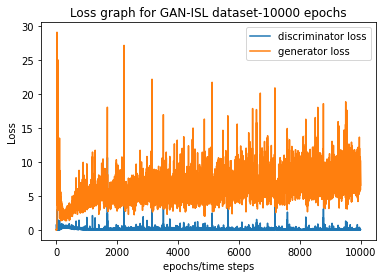

In [ ]:
import matplotlib.pyplot as plt
plt.plot(disc_loss,label='discriminator loss')
plt.plot(gen_loss,label='generator loss')
plt.xlabel('epochs/time steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss graph for GAN-ISL dataset-10000 epochs')
plt.show()

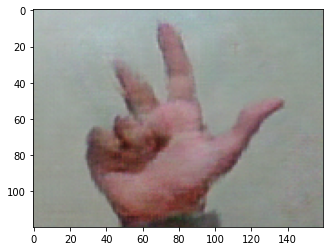

In [ ]:
#generating a random image
from numpy.random import randn
gm=load_model('drive/MyDrive/generator_model_test_ISL.h5')
vector=randn(100)
vector=vector.reshape(1,100)
image=gm.predict(vector)
image=image*0.5+0.5
plt.imshow(image[0,:,:,:])

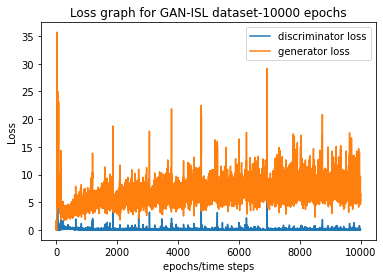

In [ ]:
import matplotlib.pyplot as plt
plt.plot(disc_loss,label='discriminator loss')
plt.plot(gen_loss,label='generator loss')
plt.xlabel('epochs/time steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss graph for GAN-ISL dataset-10000 epochs')
plt.show()

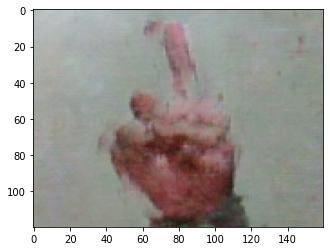

In [ ]:
#generating a random image
from numpy.random import randn
gm=load_model('drive/MyDrive/generator_model_test_ISL2.h5')
vector=randn(256)
vector=vector.reshape(1,256)
image=gm.predict(vector)
image=image*0.5+0.5
plt.imshow(image[0,:,:,:])